In [1]:
import cv2
import numpy as np
import requests
import imutils
import imageio
from IPython.display import Image, display


In [2]:
url = 'http://weather.bangkok.go.th/radar/pics/radar.gif'
with open('data.gif', 'wb') as f:
    f.write(requests.get(url).content)

In [3]:
#https://gist.github.com/Nannigalaxy/35dd1d0722f29672e68b700bc5d44767
def center_crop(img, dim):
	"""Returns center cropped image
	Args:
	img: image to be center cropped
	dim: dimensions (width, height) to be cropped
	"""
	width, height = img.shape[1], img.shape[0]

	# process crop width and height for max available dimension
	crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
	crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0] 
	mid_x, mid_y = int(width/2), int(height/2)
	cw2, ch2 = int(crop_width/2), int(crop_height/2) 
	crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
	return crop_img

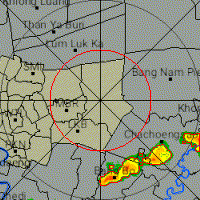

In [4]:
path = './data.gif'
out_path = './output.gif'
frames = []
lower_color = np.array([0, 0, 0], dtype = 'uint8') 
upper_color= np.array([50, 255, 255], dtype = 'uint8')

def detectRain(path, out_path, lower_color, upper_color):
    firstFrame = None
    cap = cv2.VideoCapture(path)
    while True:
        resize = (200, 200)
        
        ret, frame = cap.read()
        if not ret:
            break
        #20 - 50 dBz detect
        frame = center_crop(frame, resize)
        mask = cv2.inRange(frame, lower_color, upper_color)
        detected_output = cv2.bitwise_and(frame, frame, mask = mask) 

        gray = cv2.cvtColor(detected_output, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (3, 3), 0)

        if firstFrame is None:
            firstFrame = gray
            continue

        thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.dilate(thresh, None, iterations=1)


        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        radius = 51
        cv2.circle(frame, (int(frame.shape[1]//2), int(frame.shape[0]//2)), radius, (255, 0, 0),1)

        for c in cnts:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.drawContours(frame, cnts, -1, (255, 0, 0), 1)

            frames.append(frame)
    cap.release()
    cv2.destroyAllWindows()

    try:
        imageio.mimsave(out_path, frames, loop=0, duration = 50)
        display(Image(data=open(out_path,'rb').read(), format='png'))
    except:
        print("No data")
detectRain(path, out_path, lower_color, upper_color)